# Greenhouse Gases Pollution and Temperature Analysis for Washington

                                                                            -Maitrey Talware (mt3915)

                                                                            -Shivam Bawane (sb6818)
                                                                            

  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Table of contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Introduction </a></li>
        <li><a href="#ref2">Data Importing and Cleaning</a></li>
        <ul>
         <li><a href="#ref3">2.1 Importing Greenhouse Pollution Datset</a></li>
            <ul>
                <li><a href="#ref4">Data Transformation</a></li>
            </ul>
        <li><a href="#ref4">2.2 Importing Temperature Dataset</a></li>
        </ul>
        <li><a href="#ref5">Combining both the Dataset</a></li>
        <ul>
        <li><a href="#ref4">3.1 Normalizing the Dataset</a></li>
        </ul>
        <li><a href="#ref5">Exploratory Data Analysis</a></li>
            <ul>
                <li><a href="#ref6">4.1 Descriptive Statistics</a></li>
                <li><a href="#ref6">4.2 Line Plots</a></li>
       <li><a href="#ref6">4.3 Correlation heatmap</a></li>
        </ul>
        <li><a href="#ref7">Model /Methodology</a></li>
                    <ul>
                <li><a href="#ref6">5.1 Train - Test Split</a></li>
                <li><a href="#ref6">5.2 Data transformed to stationary</a></li>
                <li><a href="#ref6">5.3 Stationary Check</a></li>
       <li><a href="#ref6">5.4 Granger's Causality Test</a></li>
                  <li><a href="#ref6">5.5 Vector Auto Regressive Model Building</a></li>
                  <li><a href="#ref6">5.6 Prediction on test set</a></li>
                  <li><a href="#ref6">5.7 Model Evaluation</a></li>
        </ul>
        <li><a href="#ref7">Forecasting</a></li>
                    <ul>
                <li><a href="#ref6">6.1 Forecasting based on VAR model</a></li>
                <li><a href="#ref6">6.2 Forecasting Individually</a></li>
        </ul>
        <li><a href="#ref8">Result section</a></li>
        <li><a href="#ref9">Conclusion section</a></li>
    </ol>
</div>
<br>

  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 1. Introduction

Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.

  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 2. Data Importing and Data Cleaning

## 2.1 Importing and Cleaning Greenhouses gases pollution Dataset

<ul>
<li><a href="https://www.kaggle.com/sogun3/uspollution">Dataset Link </a></li>
<li>Dataset has various columns, selected only the required columns while importing</li>
<li>Based on our results from Exploratory Data Analysis we will be working on Washington</li>
</ul>

In [1]:
# ------ Importing Libraries --------
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize']=(20,10)
plt.rcParams['legend.loc']='upper left'
#plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# ------ Importing Dataset -------------
df=pd.read_csv("pollution_us_2000_2016.csv",usecols=['City','Date Local','NO2 Mean','O3 Mean','SO2 Mean','CO Mean'])
#----------- Filtering City ----------------
df=df[df['City']=='Washington']
df['Date Local']=pd.to_datetime(df['Date Local'], format='%Y-%m-%d') # Converting to datetime
# Getting to same date range as for temperature data
df=df[df['Date Local']<'2013-09-01']
# Grouping as some measurements are taken multiple timesa a day
df=df.groupby(['Date Local']).mean()
df.head()


,NO2 Mean,O3 Mean,SO2 Mean,CO Mean
Date Local,,,,
2000-01-01,26.541667,0.004167,11.237500,2.033882
2000-01-02,14.958333,0.023083,7.777083,0.770833
2000-01-03,18.291667,0.014875,7.116149,0.583333
2000-01-04,13.363636,0.017250,5.402083,0.508333
2000-01-05,16.625000,0.009583,8.362500,0.616667


### 2.1.A Data Transformations:  
<ul>
<li>Re sampling data from day to month by aggregating</li></ul>

In [2]:
#taking sum of daily values to get monthly values
df=df.resample('M').sum()
df.index = [pd.datetime(x.year, x.month, 1) for x in df.index.tolist()] 
df.head()

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean
2000-01-01,683.300847,0.364102,358.045716,32.160386
2000-02-01,539.821081,0.357543,284.939440,35.490968
2000-03-01,782.589332,0.497125,202.283723,38.381430
2000-04-01,666.711299,0.546877,156.879679,33.645470
2000-05-01,695.437038,0.865069,199.120191,26.834821


## 2.2 Importing and Cleaning Temperature Dataset
<ul>
    <li><a href="https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data">Dataset Link</a></li>
<li>Dataset has various columns, selected only the required columns while importing</li>
<li>Based on our results from Exploratory Data Analysis we will be working on Washington</li>
</ul>

In [3]:
df_t=pd.read_csv("GlobalLandTemperaturesByCity.csv",usecols=['dt','City','AverageTemperatureAnomaly'])
df_t= df_t[df_t['City']=='Washington'] #filtering for city
df_t=df_t[df_t['dt']<'2017-01-01'] # getting it to same date range as Greenhouse dataset
df_t=df_t[df_t['dt']>'1999-12-31']
df_t=df_t.set_index('dt')
df_t=df_t.drop('City',axis=1)
df_t.head()

,AverageTemperatureAnomaly
dt,
2000-01-01,0.214
2000-02-01,0.267
2000-03-01,0.144
2000-04-01,0.165
2000-05-01,0.191


  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 3. Creating a Combined Dataset

In [4]:
data=df.join(df_t) #joining dataset on Index
data2=data
data.head()

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,AverageTemperatureAnomaly
2000-01-01,683.300847,0.364102,358.045716,32.160386,0.214
2000-02-01,539.821081,0.357543,284.939440,35.490968,0.267
2000-03-01,782.589332,0.497125,202.283723,38.381430,0.144
2000-04-01,666.711299,0.546877,156.879679,33.645470,0.165
2000-05-01,695.437038,0.865069,199.120191,26.834821,0.191


### 3.1 Normalizing the Dataset
<ul>
    <li>Using min max scaler to normalize the data</li>
</ul>

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data[['NO2 Mean', 'O3 Mean','SO2 Mean','CO Mean','AverageTemperatureAnomaly']] = min_max_scaler.fit_transform(data[['NO2 Mean', 'O3 Mean','SO2 Mean','CO Mean','AverageTemperatureAnomaly']])
data.head()

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,AverageTemperatureAnomaly
2000-01-01,0.614961,0.166506,0.829139,0.419579,0.326340
2000-02-01,0.435564,0.160716,0.648301,0.469367,0.449883
2000-03-01,0.739105,0.283944,0.443841,0.512575,0.163170
2000-04-01,0.594219,0.327867,0.331529,0.441779,0.212121
2000-05-01,0.630135,0.608778,0.436016,0.339969,0.272727


  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 4. Exploratory Data Analysis

### 4.1 Descriptive Statistics

In [6]:
data.describe()

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,AverageTemperatureAnomaly
count,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.476076,0.482548,0.324394,0.348929,0.447837
std,0.186617,0.248803,0.199676,0.161680,0.187666
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.347460,0.273561,0.176674,0.234150,0.316434
50%,0.476671,0.455793,0.299104,0.338870,0.419580
75%,0.599332,0.664715,0.443233,0.459714,0.546620
max,1.000000,1.000000,1.000000,1.000000,1.000000


### 4.2.A Line chart 

In [7]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

### Built an interactive graph which shows Greenhouse gases emission over time

In [8]:
data.iplot(kind='line', xTitle='Time (years)',yTitle='Greenhouses gases in ppm', title='Greenhouses gases and Temp Anamoly Emission over Time')

### 4.2.A Ploting Individually 
<ul>
    <li>To observe trend, ploting features individually</li>
</ul>

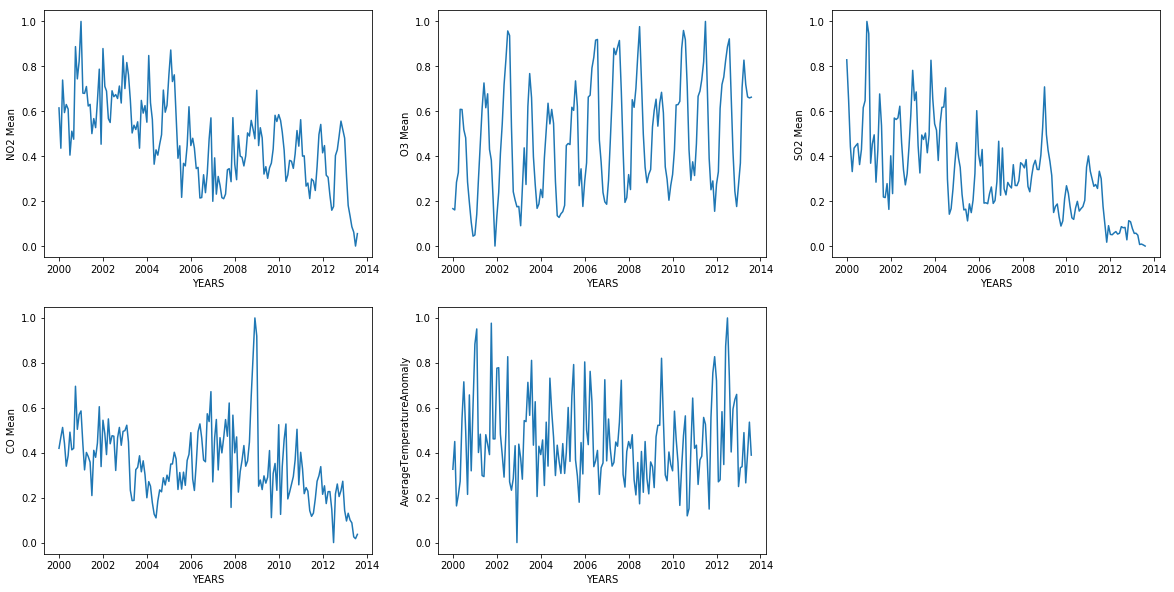

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.plot(data['NO2 Mean'])
plt.xlabel("YEARS")
plt.ylabel('NO2 Mean')

plt.subplot(2, 3, 2)
plt.plot(data['O3 Mean'])
plt.xlabel("YEARS")
plt.ylabel('O3 Mean')

plt.subplot(2, 3, 3)
plt.plot(data['SO2 Mean'])
plt.xlabel("YEARS")
plt.ylabel('SO2 Mean')

plt.subplot(2, 3, 4)
plt.plot(data['CO Mean'])
plt.xlabel("YEARS")
plt.ylabel('CO Mean')

plt.subplot(2, 3, 5)
plt.plot(data['AverageTemperatureAnomaly'])
plt.xlabel("YEARS")
plt.ylabel('AverageTemperatureAnomaly')


plt.show()

### ***Observations***: According to datset we can see :-
***1. NO2 is showing Decreasing Trend***

***2. O3 is showing Increasing Trend***
***3. SO2 is showing Decreasing Trend ***

***4. CO is showing Decreasing trend***

***5. AverageTemperatureAnomaly is showing lot of fluctuations***

### 4.3.A Correlation

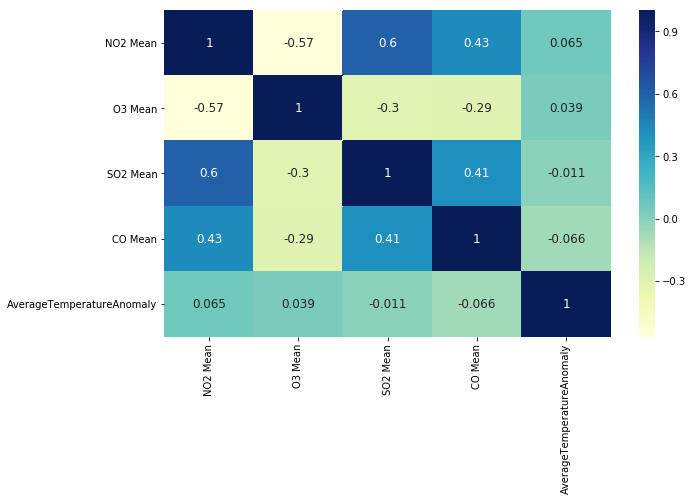

In [10]:
corr=data.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,cmap='YlGnBu',annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
#corr

It is neccesary to remove trend before calculating correlation. We remove seasonality from data by taking first order differencing
### 4.3.B Correlation after first order differencing

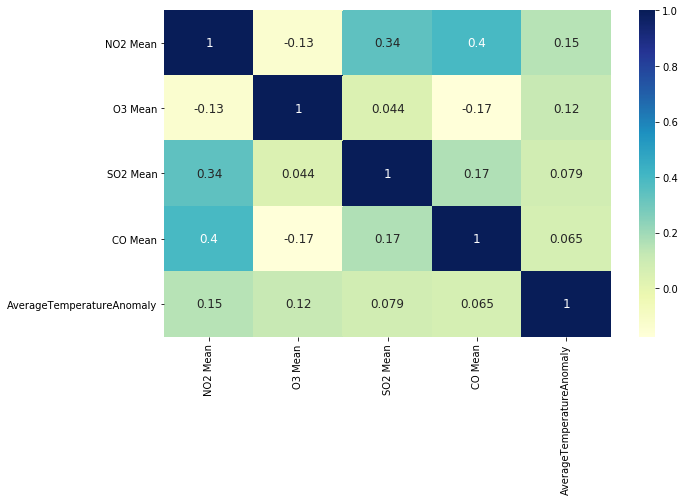

In [11]:
corr1=data.diff().dropna().corr()
sns.heatmap(corr1,xticklabels=corr1.columns.values,yticklabels=corr1.columns.values,annot=True,annot_kws={'size':12},cmap='YlGnBu')
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### *Observations:*  

**AverageTemperatureAnomaly is postively correlated to all the greenhouse gases to some extent.
This is what we want to convey through this project that temperature change is related to greenhouse gases. As correlation does not mean causation we need some strong proof to prove our point. (Done in further analysis)**

  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 5. Model Methodology 

***We will be using Vector Auto Regressive Model for Time Series Forecasting***

### 5.1 Train Test Split
<ul>
    <li>We will be spliting dataset in training and testing set</li>
</ul>

In [12]:
number_test=30
X_train,X_test=data[0:-number_test],data[-number_test:]
print(X_train.shape)
print(X_test.shape)

(134, 5)
(30, 5)


### 5.2 Transformation 
**Making the timeseries stationary is important in order to proceed**


In [13]:
transform_data=X_train.diff().dropna()
transform_data.head()

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,AverageTemperatureAnomaly
2000-02-01,-0.179398,-0.005791,-0.180838,0.049788,0.123543
2000-03-01,0.303541,0.123228,-0.204459,0.043208,-0.286713
2000-04-01,-0.144886,0.043923,-0.112313,-0.070796,0.048951
2000-05-01,0.035917,0.280911,0.104487,-0.101810,0.060606
2000-06-01,-0.020360,-0.000910,0.011099,0.046767,0.279720


### 5.3 Stationary Check
<ul>
<li>Using adfuller_test to check for stationarity as VAR works on stationary series</li>
</ul>

In [14]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series,signif=0.05,name='',verbose=False):
    r=adfuller(series,autolag='AIC')
    output={'test_statistic':round(r[0],4),'pvalue':round(r[1],4),'n_lags':round(r[2],4),'o_obs':r[3]}
    p_value=output['pvalue']
    def adjust(val,length=6):return str(val).ljust(length)
    
    print(f'Augemented Dickey Fuller Test on "{name}"',"\n ",'-'*47)
    print(f'Null Hypothesis: Data has unit root. Non Stationary')
    print(f'Significance Level   ={signif}')
    print(f'test stats   ={output["test_statistic"]}')
    print(f'No. lags chosen   ={output["n_lags"]}')
    
    for key,val in r[4].items():
          print(f'Critical Value {adjust(key)}={round(val,3)}')
    if p_value<=signif:
          print(f" => P-value={p_value}. Rejecting Null Hypothesis")
          print(f" => Series is Stationary")
          
    else:
      print(f" => P-value={p_value}. Weak, to reject Null Hypothesis")
      print(f" => Series is Non-Stationary")

for name, column in transform_data.iteritems():
          adfuller_test(column,name=column.name)
          print("\n")


Augemented Dickey Fuller Test on "NO2 Mean" 
  -----------------------------------------------
Null Hypothesis: Data has unit root. Non Stationary
Significance Level   =0.05
test stats   =-3.0861
No. lags chosen   =13
Critical Value 1%    =-3.487
Critical Value 5%    =-2.886
Critical Value 10%   =-2.58
 => P-value=0.0276. Rejecting Null Hypothesis
 => Series is Stationary


Augemented Dickey Fuller Test on "O3 Mean" 
  -----------------------------------------------
Null Hypothesis: Data has unit root. Non Stationary
Significance Level   =0.05
test stats   =-9.8827
No. lags chosen   =9
Critical Value 1%    =-3.485
Critical Value 5%    =-2.885
Critical Value 10%   =-2.579
 => P-value=0.0. Rejecting Null Hypothesis
 => Series is Stationary


Augemented Dickey Fuller Test on "SO2 Mean" 
  -----------------------------------------------
Null Hypothesis: Data has unit root. Non Stationary
Significance Level   =0.05
test stats   =-7.508
No. lags chosen   =5
Critical Value 1%    =-3.483
Criti

***We see that each series in stationary after first order differencing*** 
(proceeding further)

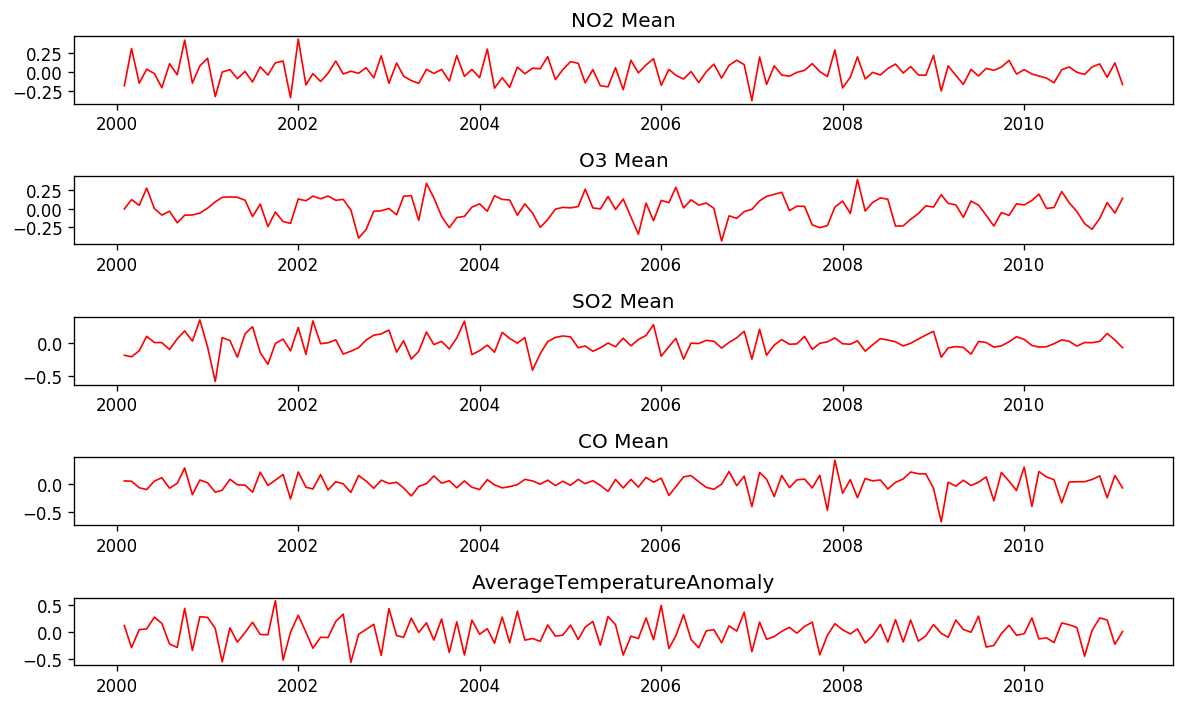

In [15]:
fig,axes=plt.subplots(nrows=5,ncols=1,dpi=120,figsize=(10,6))
for i,ax in enumerate(axes.flatten()):
    data=transform_data[transform_data.columns[i]]
    ax.plot(data,color='red',linewidth=1)
    ax.set_title(transform_data.columns[i])
plt.tight_layout();
    

**We have reached at stage where we want to prove that temperature change is caused by Greenhouse gases. As we know correlation is not enough to prove so. We will apply Granger's Causality Test**

# 5.4 Granger’s Causality Test

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=5
test="ssr_chi2test"
def grangers_causation_matrix(data,variables,test='ssr_chi2test',verbose=False):
    xtrain=pd.DataFrame(np.zeros((len(variables),len(variables))),columns=variables,index=variables)
    for c in xtrain.columns:
        for r in xtrain.index:
            test_result=grangercausalitytests(data[[r,c]],maxlag=maxlag,verbose=False)
            p_values=[round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose:print(f'Y={r},X={c},P Values={p_values}')
            min_p_value=np.min(p_values)
            xtrain.loc[r,c]=min_p_value
    xtrain.columns=[var+'_x' for var in variables]
    xtrain.index=[var+'_y' for var in variables]
    return xtrain
grangers_causation_matrix(data2,variables=data2.columns)  

,NO2 Mean_x,O3 Mean_x,SO2 Mean_x,CO Mean_x,AverageTemperatureAnomaly_x
NO2 Mean_y,1.0000,0.0000,0.0904,0.0714,0.0987
O3 Mean_y,0.0000,1.0000,0.0091,0.4324,0.3200
SO2 Mean_y,0.0034,0.0079,1.0000,0.0005,0.0090
CO Mean_y,0.6391,0.0337,0.2297,1.0000,0.3397
AverageTemperatureAnomaly_y,0.4422,0.3920,0.5202,0.2824,1.0000


### Result of this test shows that NO2_mean_x, O3 Mean_x, SO2 Mean_x, CO Mean_x causes AverageTemperatureAnomaly_y	

# Cointegration Test

In [17]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(transform_data,alpha=0.05):
    out=coint_johansen(transform_data,-1,5)
    d={'0.90':0,'0.95':1,'0.99':2}
    traces=out.lr1
    cvts=out.cvt[:,d[str(1-alpha)]]
    def adjust(val,length=6):return str(val).ljust(length)
    
    print("Name : Test Stat > c(95%) ==> Signif \n, '--'*20")
    for col, trace,cvt in zip(transform_data.columns,traces,cvts):
        print(adjust(col),'::',adjust(round(trace,2),9), ">",adjust(cvt,8),' => ',trace >cvt)
cointegration_test(X_train)

Name : Test Stat > c(95%) ==> Signif 
, '--'*20
NO2 Mean :: 75.82     > 60.0627   =>  True
O3 Mean :: 39.1      > 40.1749   =>  False
SO2 Mean :: 15.12     > 24.2761   =>  False
CO Mean :: 4.44      > 12.3212   =>  False
AverageTemperatureAnomaly :: 0.18      > 4.1296    =>  False


# 5.5 Vector Auto Regressive Model


1. Vector Autoregression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other. That is, the relationship between the time series involved is bi-directional.
2. A Vector autoregressive (VAR) model is useful when one is interested in predicting multiple time series variables using a single model. At its core, the VAR model is an extension of the univariate autoregressive model we have dealt with in class
3. Main requirement of VAR model is that it requires stationarity of series, which we confirmed from augmennted Dickey-Fuller Test
4. We are using VAC as VAR model is a popular tool for the purpose of predicting joint dynamics of multiple time series based on linear functions of past observations. ***It will help us predict Temperature Anamoly based of previous values of Greenhouse gases***

In [18]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
mod = smt.VAR(transform_data)
# giving maxlags parameter select best lag order within 15
res = mod.fit(maxlags=15, ic="aic")

In [19]:
lag_order=res.k_ar #gives best lag order
pred=res.forecast(transform_data.values[-lag_order:],number_test) #forecast to compare to testing set
pred_df=pd.DataFrame(pred,index=data2.index[-number_test:],columns=data2.columns)
pred_df.head(2)

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,AverageTemperatureAnomaly
2011-03-01,0.034332,0.007267,-0.128470,-0.086009,-0.178279
2011-04-01,-0.048651,0.084547,-0.064904,-0.027165,0.018016


### 5.5.1 De differencing data (invert Transform)


In [20]:
pred_inverse=pred_df.cumsum() #we are reverse differencing
f=pred_inverse+X_test # inverse the difference values
f.head(2)

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,AverageTemperatureAnomaly
2011-03-01,0.435978,0.673871,0.172146,0.131648,0.080462
2011-04-01,0.252584,0.781899,0.072505,0.131490,0.208035


# 5.6 Prediction on test set

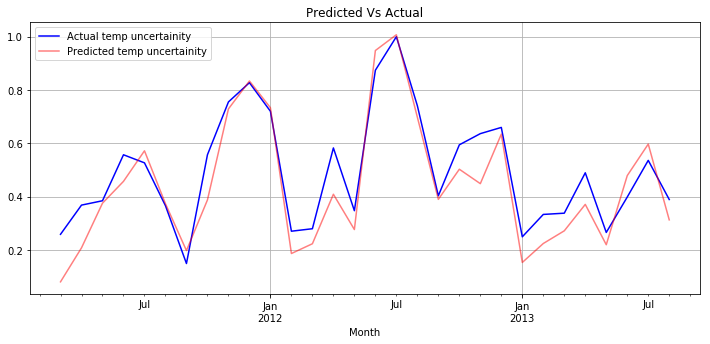

In [21]:
plt.figure(figsize=(12,5))
plt.xlabel('Month')
ax1=X_test.AverageTemperatureAnomaly.plot(color='blue',grid=True,label='Actual temp uncertainity')
ax2=f.AverageTemperatureAnomaly.plot(color='red',grid=True,label='Predicted temp uncertainity',alpha=0.5)
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title("Predicted Vs Actual")
plt.show()

### Observation:
#### ***We observe that model built from greenhouse gases and Temperature anamoly predicts testing data for Temperature Anamoly effectively.***

# 5.7 Model Evaluation
<ul>
    <li>Calculating Bias</li>
    <li>Calculating Mean Absolute Error</li>
    <li>Calculating Mean Squared Error</li>
    <li>Calculating Root Mean Squared Error</li>
    
</ul>

In [22]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
m=['AverageTemperatureAnomaly']
for quant in m:
    forecast_errors=[X_test[quant][i]-f[quant][i] for i in range(len(X_test[quant]))]
    print('Evaluation for',quant)
    bias=sum(forecast_errors)*1.0/len(X_test[quant])
    print('Bias: %f' %bias)

    mae=mean_absolute_error(X_test[quant],f[quant])
    print('MAE: %f'%mae)

    mse=mean_squared_error(X_test[quant],f[quant])
    print('MSE: %f'%mse)

    rmse=sqrt(mse)
    print('RMSE: %f' %rmse)



Evaluation for AverageTemperatureAnomaly
Bias: 0.051916
MAE: 0.074803
MSE: 0.008547
RMSE: 0.092450


  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 6. Forecasting

## 6.1 Forecasting next 20 Months with VAR Model

In [23]:
res

<Figure size 432x288 with 0 Axes>

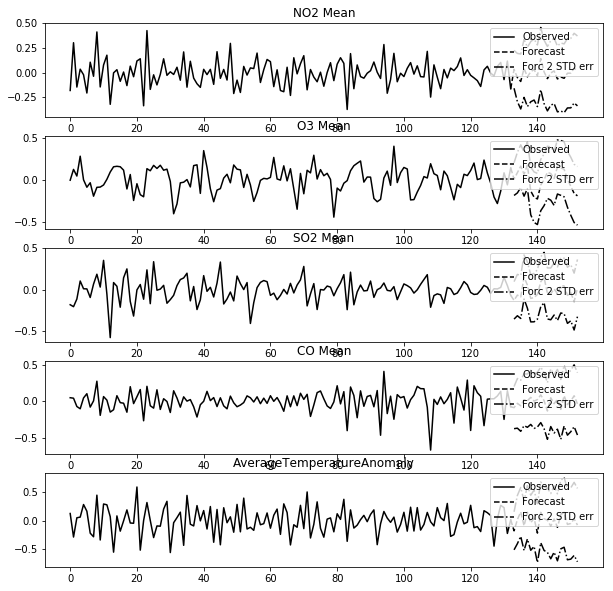

In [27]:
plt.figure()
res.plot_forecast(20)
# plt.legend(loc='upper left')
plt.show()

## 6.2 Forecasting Individually on Temperature Change for next (20 Years)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


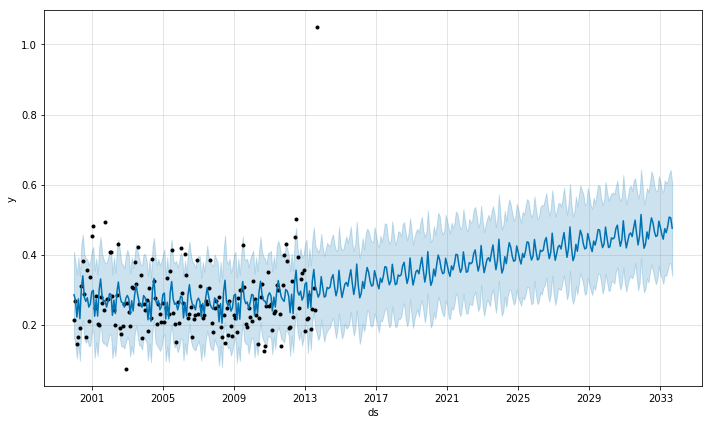

In [25]:
from fbprophet import Prophet

# Create a new DataFrame with which we will create/train our Prophet model 
t_prophet = pd.DataFrame()
t_prophet['ds'] = df_t.index
t_prophet['y'] = df_t['AverageTemperatureAnomaly'].values

# Instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(t_prophet)

# Generate future dataframe containing predictions (we are doing this for 100 years into the future)
future = m.make_future_dataframe(freq='m', periods=20*12)
forecast = m.predict(future)

# Plot the resulting forecast
m.plot(forecast)
plt.show()

  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 7. Result Section


***We have successfully shown the correlation between temperature change and greenhouse gases. To further bolster our point we used the Granger Causality test to show that previous data of greenhouses gases helps predict temperature change.
We Evaluated our Multivariate Vector Autoregression model by calculating Bias, Mean Squared Error, Mean Absolute Error, Root Mean Square Error. Good Results obtained ***

  **-------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# 8. Conclusion Section

 ***Everyone has a moral obligation towards the planet we live on. We as Computer Science students we contribute towards building a better future by proving and creating awareness by our project. We conclude by saying that the temperature change is real. We explain our code to make it easier for everyone to understand and think about our Earth.***